# Udacity CarND Term1 Proj5 Vehicle Detection
* Joe Zhou
* ibalpowr@gmail.com

In [1]:
cd /ibalpowr/workbench/term1-proj5

/ibalpowr/workbench/term1-proj5


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from time import time

%matplotlib inline

# for generating HoG
from skimage.feature import hog

from skimage.transform import resize

# for normalizing dataset
from sklearn.preprocessing import StandardScaler

# for SVM classifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

import pickle

# for clustering
from scipy.ndimage.measurements import label

# for video frame buffering
from collections import deque

# for display some random images
import random

# import and explore training images
* each image 64x64

In [3]:
vehicles = []
others = []
vehicles_images = glob.glob('data/vehicles/*/*.png')
others_images = glob.glob('data/non-vehicles/*/*.png')
for images in vehicles_images:
    vehicles.append(mpimg.imread(images))
for images in others_images:
    others.append(mpimg.imread(images))

In [4]:
# convert to array
vehicles = np.asarray(vehicles)
others = np.asarray(others)

### explore dataset

In [5]:
vehicles.dtype

dtype('float32')

In [6]:
vehicles.shape

(8792, 64, 64, 3)

In [7]:
others.shape

(8968, 64, 64, 3)

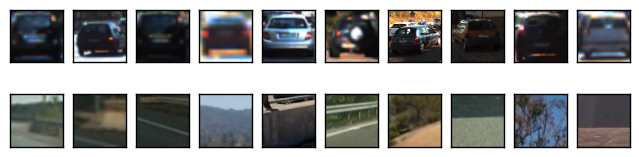

In [8]:
# randomly display ten images from each class
fig = plt.figure(figsize = (8,2))
random_idx_vehicles = random.sample(range(0, vehicles.shape[0]),10)
random_idx_others = random.sample(range(0, others.shape[0]),10)
for i in range(10):
    axis = fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    axis.imshow(vehicles[random_idx_vehicles[i]])
for i in range(10):
    axis = fig.add_subplot(2,10,i+10+1,xticks=[],yticks=[])
    axis.imshow(others[random_idx_others[i]])

# explore hog images
* pix_per_cell = 8
* cell_per_block = 2
* orient = 10

### setup hog parameters

In [9]:
orient = 10
pix_per_cell = 8
cell_per_block = 2

In [10]:
def visualize_hog(image, orient=orient, pix_per_cell=pix_per_cell, 
                  cell_per_block=cell_per_block):
    hog_image = []
    for d in range(image.shape[2]):
        _, hog_img = hog(image[:,:,d], visualise=True,
                        feature_vector=False,
                        orientations = orient,
                        pixels_per_cell=(pix_per_cell,pix_per_cell), 
                        cells_per_block=(cell_per_block,cell_per_block))   
        hog_image.append(hog_img)
    return np.array(hog_image)

### show only Y channel

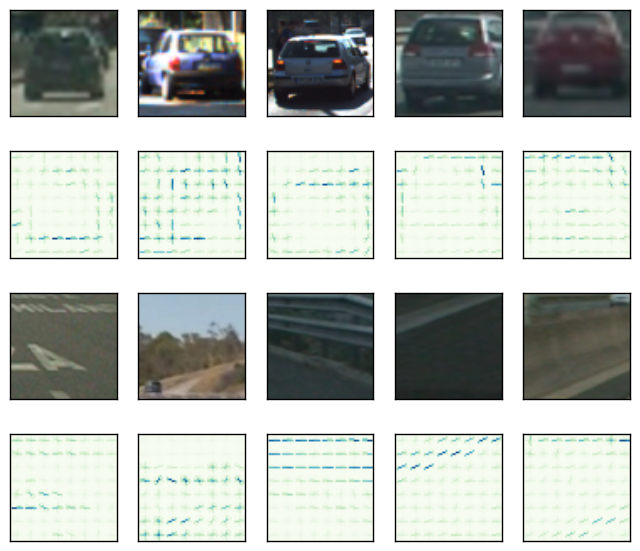

In [11]:
# randomly display five images from each class and their hog images in channel Y
fig = plt.figure(figsize = (8,7))
random_idx_vehicles = random.sample(range(0, vehicles.shape[0]),5)
random_idx_others = random.sample(range(0, others.shape[0]),5)
for i in range(5):
    axis = fig.add_subplot(4,5,i+1,xticks=[],yticks=[])
    axis.imshow(vehicles[random_idx_vehicles[i]])
for i in range(5):
    axis = fig.add_subplot(4,5,i+5+1,xticks=[],yticks=[])
    axis.imshow(visualize_hog(vehicles[random_idx_vehicles[i]])[0],cmap='GnBu')
for i in range(5):
    axis = fig.add_subplot(4,5,i+10+1,xticks=[],yticks=[])
    axis.imshow(others[random_idx_others[i]])
for i in range(5):
    axis = fig.add_subplot(4,5,i+15+1,xticks=[],yticks=[])
    axis.imshow(visualize_hog(others[random_idx_others[i]])[0],cmap='GnBu')

### show all YCrCb channels

In [12]:
def show_hog(image):
    # convert to a different color space for higher classification accuracy
    # it can be RGB, cv2.COLOR_RGB2YCrCb, cv2.COLOR_RGB2HLS, ...
    # image_new = image      # for RGB
    image_new = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    
    hog_image = visualize_hog(image_new)
  
    # display each hog image
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (10,3))
    ax1.imshow(image)
    ax1.set_title('original image', fontsize= 15)
    ax2.imshow(hog_image[0], cmap='GnBu')
    ax2.set_title('hog image (Y)', fontsize = 15, color='red')
    ax3.imshow(hog_image[1], cmap='GnBu')
    ax3.set_title('hog image (Cr)', fontsize= 15, color='red')
    ax4.imshow(hog_image[2], cmap='GnBu')
    ax4.set_title('hog image (Cb)', fontsize = 15, color='red')

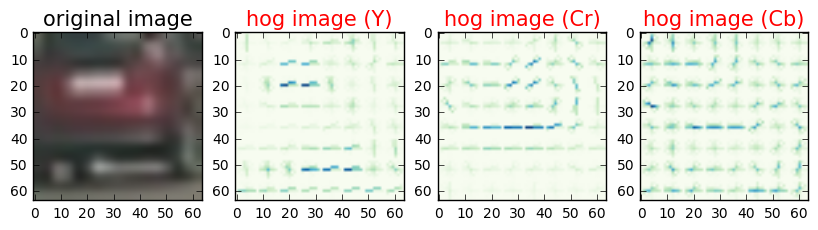

In [13]:
show_hog(vehicles[np.random.randint(0,len(vehicles),1)[0]])

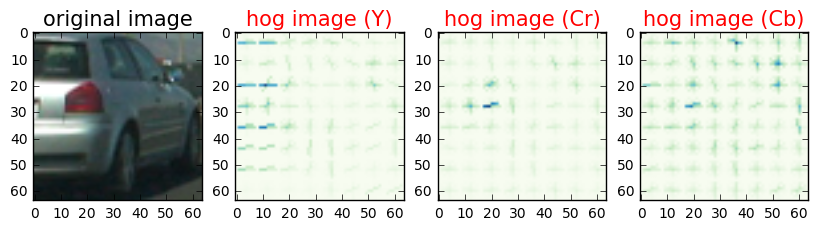

In [14]:
show_hog(vehicles[np.random.randint(0,len(vehicles),1)[0]])

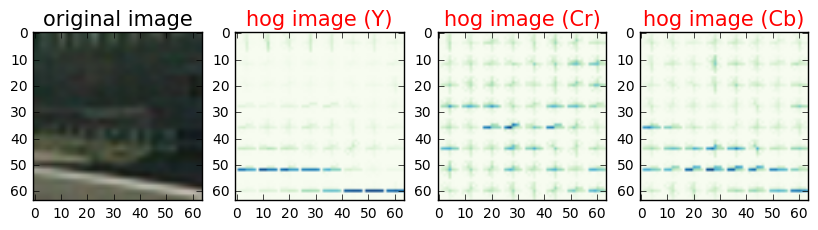

In [15]:
show_hog(others[np.random.randint(0,len(others),1)[0]])

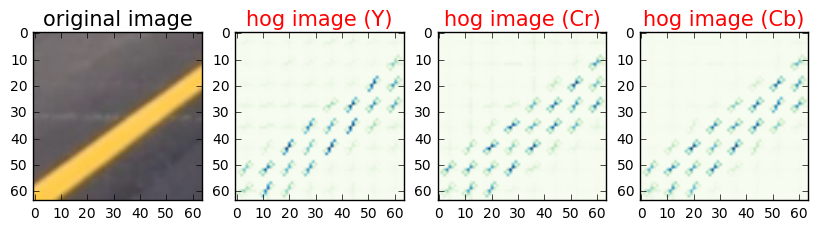

In [16]:
show_hog(others[np.random.randint(0,len(others),1)[0]])

# train a SVM classifier
* this section should run only once
* be skipped later

### setup hog parameters

In [17]:
orient = 10
pix_per_cell = 8
cell_per_block = 2

### get hog features for vehicles set and non-vehicles set
* use YCrCb colorspace, which is better than RGB and HLS in reducing number of false positives

In [18]:
vehicle_features = []
for i in range(len(vehicles)):
    image = cv2.cvtColor(vehicles[i], cv2.COLOR_RGB2YCrCb)
    vehicle_channel_features = []
    for channel in range(image.shape[2]):
        vehicle_channel_features.append(hog(image[:, :, channel], \
                    orientations=orient, \
                    pixels_per_cell=(pix_per_cell,pix_per_cell), \
                    cells_per_block=(cell_per_block,cell_per_block), \
                    transform_sqrt=True, \
                    visualise=False, \
                    feature_vector=False, \
                    normalise=None))
    vehicle_channel_features = np.ravel(vehicle_channel_features)
    vehicle_features.append(vehicle_channel_features)

In [19]:
other_features = []
for i in range(len(others)):
    image = cv2.cvtColor(others[i], cv2.COLOR_RGB2YCrCb)
    other_channel_features = []
    for channel in range(image.shape[2]):
        other_channel_features.append(hog(image[:, :, channel], \
                    orientations=orient, \
                    pixels_per_cell=(pix_per_cell, pix_per_cell), \
                    cells_per_block=(cell_per_block, cell_per_block), \
                    transform_sqrt=True, \
                    visualise=False, \
                    feature_vector=False, \
                    normalise=None))
    other_channel_features = np.ravel(other_channel_features)
    other_features.append(other_channel_features)

In [20]:
print(len(vehicle_features))
print(len(other_features))
print()
print(vehicle_features[0].shape)
# 7*7 * 2*2 * 10 = 1960
# 1960 * 3 = 5880

8792
8968

(5880,)


### prepare training set and labels
* standardize features by removing the mean and scaling to unit variance

In [21]:
vehicle_features = np.asarray(vehicle_features)
other_features = np.asarray(other_features)
X = np.vstack((vehicle_features, other_features)).astype(np.float64)

# compute the mean and std to be used for later scaling
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

In [22]:
# a hack in creating ground truth labels
labels = np.hstack((np.ones(len(vehicle_features)), 
                    np.zeros(len(other_features))))

### start training

In [23]:
print('training a svm classifier ...')
X_train, X_test, y_train, y_test = \
    train_test_split(scaled_X,labels,test_size=0.2,random_state=86)
svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = round(svc.score(X_test, y_test), 4)
print('... done')
print('accuracy = ', accuracy)

training a svm classifier ...
... done
accuracy =  0.9825


### save X and svc as pickle files

In [24]:
pickle.dump(X, open( "term1-proj5-car_training_set.p", "wb" ))
pickle.dump(svc, open( "term1-proj5-car_svc.p", "wb" ))

# load a SVM classifier
* run this section after SVM classifier has been trained and saved

In [25]:
X = pickle.load(open("term1-proj5-car_training_set.p","rb"))
X_scaler = StandardScaler().fit(X)
svc = LinearSVC()
svc = pickle.load(open("term1-proj5-car_svc.p","rb"))

# define a few helper functions for the pipeline
* return hog features and hog sizes
* use all YCrCb channels

In [26]:
# return a scaled image
def prepare_image(image, scale):
    (h,w,d) = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    scaled_image = resize((image / 255.).astype(np.float64), \
                      (int(h * scale), int(w * scale), d), \
                      preserve_range=True).astype(np.float32)
    return scaled_image

# from hog-svm paper [2005]
# find hog size ... given image size, pix_per_cell, cell_per_block
def find_hogsize(imagesize, pix_per_cell, cell_per_block):
    block_overlap = np.ceil(cell_per_block/2)
    return np.int(np.floor(1+(imagesize//pix_per_cell-cell_per_block)/
                           (cell_per_block-block_overlap)))

# the inverse of find_hogsize()
# find image size
def find_imagesize (hogsize, pix_per_cell, cell_per_block):
    block_overlap = np.ceil(cell_per_block/2)
    return np.int(np.floor(((hogsize-1)*(cell_per_block-block_overlap)+ 
                           cell_per_block)*pix_per_cell))

# find hog features of an image
# in shape of 3x7x7x2x2x10 for above given hog parameters
def hog_image(image, orient, pix_per_cell, cell_per_block, kernel):
    (h,w,d) = image.shape
    image_hog_features = []
    for channel in range(d):
        image_hog_features.append(hog(image[:, :, channel], 
                        orientations=orient, 
                        pixels_per_cell=(pix_per_cell,pix_per_cell), 
                        cells_per_block=(cell_per_block,cell_per_block), 
                        transform_sqrt=True, 
                        visualise=False, 
                        feature_vector=False))
    image_hog_features = np.asarray(image_hog_features)
    hog_k = find_hogsize(kernel, pix_per_cell, cell_per_block)
    hog_h = image_hog_features.shape[1]
    hog_w = image_hog_features.shape[2]
    return image_hog_features, hog_h, hog_w, hog_k

# try out sliding windows on a test image
* test_images/test3.jpg
* lower half of an image
* one scale 0.8
* overlap: 6

In [27]:
image = mpimg.imread('test_images/test3.jpg')
image_original = np.copy(image)
image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
(h,w,d) = image_original.shape
print(image.shape)

(720, 1280, 3)


In [28]:
scale = 0.8
scaled_image = resize((image_original / 255.).astype(np.float64), \
                      (int(h * scale), int(w * scale), d), \
                      preserve_range=True).astype(np.float32)
(h,w,d) = scaled_image.shape
print(h,w,d)

576 1024 3


### for no overlap among sliding windows

In [29]:
# only lower half of the image
y_ratio = 0.5
y_top = int(h*y_ratio)

# sliding window size
k = 64

# overlap
overlap = 1

In [30]:
x_range = np.linspace(0, w-k, (w//k)*overlap).astype(np.int)
y_range = np.linspace(y_top, h-k, ((h-y_top)//k)*overlap).astype(np.int)

print(x_range)
print(y_range)

[  0  64 128 192 256 320 384 448 512 576 640 704 768 832 896 960]
[288 362 437 512]


In [31]:
# find out bounding boxes
bboxes = np.empty([0,4], dtype=np.int)
for y in y_range:
    for x in x_range:
        bboxes = np.append(bboxes, [[x,y,x+k,y+k]],axis=0)

In [32]:
bboxes.shape

(64, 4)

In [33]:
scaled_image_copy = np.copy(scaled_image)
for c in bboxes:
    cv2.rectangle(scaled_image_copy,(c[0],c[1]),(c[2],c[3]),(0.,0.,1.),2)

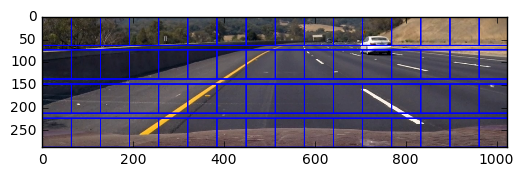

In [34]:
# the case of no overlapping
plt.imshow(scaled_image_copy[h//2:,:,:])

### for overlapping ... 6x6 (i.e. 36) times the number of sliding windows

In [35]:
# overlap
overlap = 6

In [36]:
x_range = np.linspace(0, w-k, (w//k)*overlap).astype(np.int)
y_range = np.linspace(y_top, h-k, ((h-y_top)//k)*overlap).astype(np.int)

print(x_range)
print(y_range)

[  0  10  20  30  40  50  60  70  80  90 101 111 121 131 141 151 161 171
 181 192 202 212 222 232 242 252 262 272 282 293 303 313 323 333 343 353
 363 373 384 394 404 414 424 434 444 454 464 474 485 495 505 515 525 535
 545 555 565 576 586 596 606 616 626 636 646 656 666 677 687 697 707 717
 727 737 747 757 768 778 788 798 808 818 828 838 848 858 869 879 889 899
 909 919 929 939 949 960]
[288 297 307 317 326 336 346 356 365 375 385 395 404 414 424 434 443 453
 463 473 482 492 502 512]


In [37]:
# find out bounding boxes
bboxes = np.empty([0,4], dtype=np.int)
for y in y_range:
    for x in x_range:
        bboxes = np.append(bboxes, [[x,y,x+k,y+k]],axis=0)

In [38]:
bboxes.shape

(2304, 4)

In [39]:
scaled_image_copy = np.copy(scaled_image)
for c in bboxes:
    cv2.rectangle(scaled_image_copy,(c[0],c[1]),(c[2],c[3]),(0.,0.,1.),1)

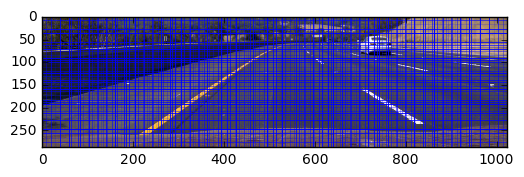

In [40]:
# with overlapping ... 6
# line width = 1 ... to show higher clarity
plt.imshow(scaled_image_copy[h//2:,:,:])

# predict/classify each hog feature
* i.e. each 7x7 hog image

In [41]:
# input hog features: in shape of 3x7x7x2x2x10
def predict_hog_features (image_hog_features,y_ratio,hog_h,hog_w,hog_k,
                          pix_per_cell,cell_per_block,overlap,scale):
    
    # create an empty array to store 
    # the coordinates of detection positives 
    detections = np.empty([0,4], dtype=np.int)
    
    hog_y_top = int(hog_h*y_ratio)
    
    # set up sliding windows for hog features
    hog_x_range = np.linspace(0, hog_w-hog_k, 
                        (hog_w//hog_k)*overlap).astype(np.int)
    hog_y_range = np.linspace(hog_y_top, hog_h-hog_k, 
                        ((hog_h-hog_y_top)//hog_k)*overlap).astype(np.int)
    
    # scan thru hog features and classify each sliding window
    for hog_y in hog_y_range:
        for hog_x in hog_x_range:
            one_hog_feature=np.ravel(image_hog_features[:,
                                hog_y:hog_y+hog_k, 
                                hog_x:hog_x+hog_k,:,:,:]).reshape(1,-1)
            if svc.predict(X_scaler.transform(one_hog_feature))[0] == 1:
                c1=find_imagesize(hog_x,pix_per_cell,cell_per_block)
                c2=find_imagesize(hog_y,pix_per_cell,cell_per_block)
                c3=find_imagesize(hog_x+hog_k,pix_per_cell,cell_per_block)
                c4=find_imagesize(hog_y+hog_k,pix_per_cell,cell_per_block)
                detections=np.append(detections,[[c1,c2,c3,c4]],axis=0)
                
    return (detections/scale).astype(np.int)

### try out on a test image
* a single scale

In [42]:
scale = 0.8
kernel = 64

In [43]:
# creat a placeholder for detection results
detections = np.empty([0,4], dtype=np.int)

In [44]:
image = mpimg.imread('test_images/test1.jpg')
image_original = np.copy(image)

In [45]:
scaled_image = prepare_image(image, scale)       

In [46]:
image_hog_features,hog_h,hog_w,hog_k=hog_image(scaled_image,
                                        orient=orient,
                                        pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block,
                                        kernel=kernel)

In [47]:
# make prediction on all hog's
detections=predict_hog_features(image_hog_features=image_hog_features,
                                     y_ratio=y_ratio,
                                     hog_h=hog_h,
                                     hog_w=hog_w,
                                     hog_k=hog_k,
                                     pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,
                                     overlap=overlap,
                                     scale=scale)

In [48]:
detections.shape

(45, 4)

In [49]:
image_detections = np.copy(image_original)
for c in detections:
    cv2.rectangle(image_detections,(c[0],c[1]),(c[2],c[3]),(0,0,255),2)

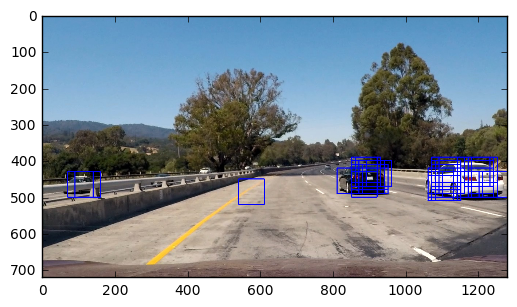

In [50]:
# showing the predictions
plt.imshow(image_detections)

# use heatmap to suppress false positives

In [51]:
def car_cluster(detections_history, image, threshold=1):
    
    # create a image-size heatmap
    heatmap = np.zeros((image.shape[0],image.shape[1])).astype(np.float)
    
    # update the heatmap
    for bbox in detections_history:
        (x1,y1,x2,y2) = (bbox[0],bbox[1],bbox[2],bbox[3])
        heatmap[y1:y2, x1:x2] += 1

    # set lower bound
    heatmap[heatmap < threshold] = 0
    # set upper bound
    heatmap = np.clip(heatmap, 0, 255)
    
    # make car clusters 
    labeled_heatmap, car_number = label(heatmap)
    
    cars = np.empty([0, 4], dtype=np.int64)
    for car in range(car_number):
        nonzero = (labeled_heatmap == (car+1)).nonzero()
        (x1,y1,x2,y2) = (np.min(nonzero[1]),np.min(nonzero[0]), 
                         np.max(nonzero[1]+1),np.max(nonzero[0]+1))
        cars = np.append(cars,[[x1, y1, x2, y2]], axis=0)
    
    # (x1,y1,x2,y2)   ...  image_size heatmap
    return (cars, heatmap)

In [52]:
y_ratio = 0.5
overlap = 6
orient = 10
pix_per_cell = 8
cell_per_block = 2
kernel = 64
threshold = 6

In [53]:
# on a single frame ... with two scales
def detect_frame(image):
    detections_history = np.empty([0,4], dtype=np.int)
    image_original = np.copy(image)
    scales = [0.7,0.8]
    for scale in scales:
        scaled_image = prepare_image(image, scale)
        image_hog_features,hog_h,hog_w,hog_k=hog_image(scaled_image,
                                        orient=orient,
                                        pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block,
                                        kernel=kernel)
        detections=predict_hog_features(
                            image_hog_features=image_hog_features,
                            y_ratio=y_ratio,
                            hog_h=hog_h,
                            hog_w=hog_w,
                            hog_k=hog_k,
                            pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            overlap=overlap,
                            scale=scale)
        detections_history=np.append(detections_history,detections,axis=0)
    heatmap = np.zeros((image.shape[0],image.shape[1])).astype(np.float)
    cars = np.empty([0, 4], dtype=np.int64)
    cars, heatmap = car_cluster(detections_history=detections_history,
                                image=image,
                                threshold=threshold)
    
    return cars, heatmap

# detect all test images
* process and display all test iamges

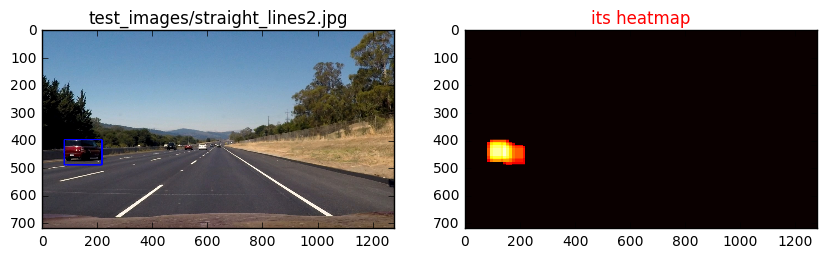

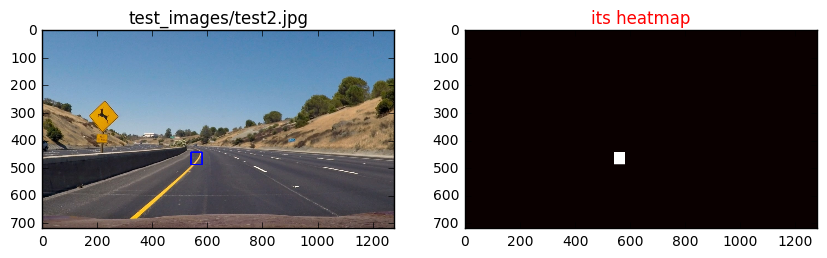

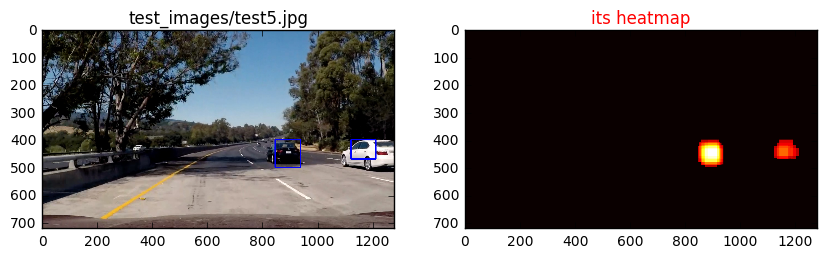

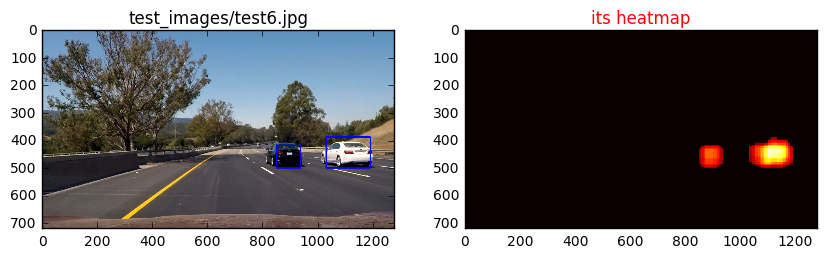

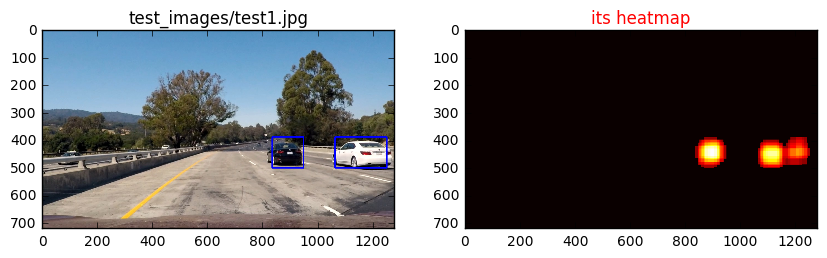

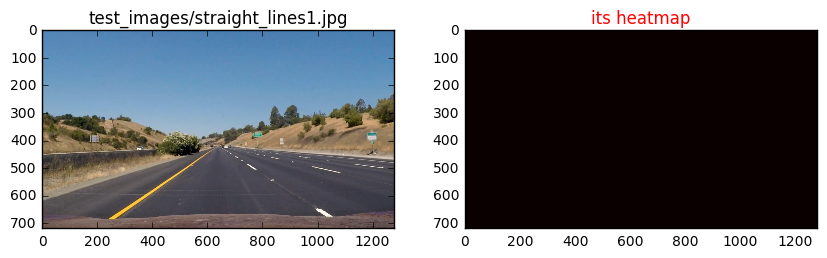

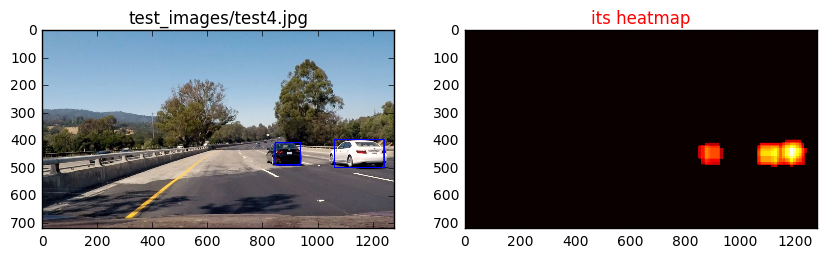

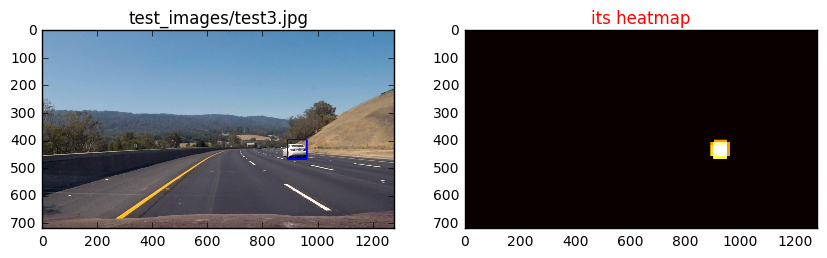

In [54]:
for image_name in glob.glob('test_images/*.jpg'):
    detections_history = np.empty([0,4], dtype=np.int)
    image = mpimg.imread(image_name)
    image_original = np.copy(image)
    detections_history, heatmap = detect_frame(image)
    image_cars = np.copy(image_original)
    for c in detections_history:
        cv2.rectangle(image_cars, (c[0],c[1]),(c[2],c[3]),(0,0,255),4)
    mpimg.imsave(image_name.replace('test_images', 'output_images'), 
                 image_cars)
    mpimg.imsave(image_name.replace('test_images', 'heatmap_images'), 
                 heatmap)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,3))
    ax1.imshow(image_cars)
    ax1.set_title(image_name)
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('its heatmap', color='red')

# Car_Detection class
* to process video file

In [55]:
class Car_Detection(object):
    def __init__(self,frame):
        self.detections_cars = deque(maxlen=10)
    def process(self,frame):
        cars_frame,_ = detect_frame(frame)
        self.detections_cars.append(cars_frame)
        cars,_ = car_cluster(np.concatenate(
                            np.array(self.detections_cars)),frame,2)
        for c in cars:
            cv2.rectangle(frame, (c[0],c[1]),(c[2],c[3]),(0,0,255),4)
        return frame        

# process video clip

In [56]:
from moviepy.editor import VideoFileClip
video = VideoFileClip('project_video.mp4')
video_output_name = 'project_video-proj5-ibalpowr.mp4'

In [57]:
car_detect = Car_Detection(video.get_frame(0))

In [58]:
video_output = video.fl_image(car_detect.process)

In [59]:
%time video_output.write_videofile(video_output_name,audio=False)

[MoviePy] >>>> Building video project_video-proj5-ibalpowr.mp4
[MoviePy] Writing video project_video-proj5-ibalpowr.mp4


100%|█████████▉| 1260/1261 [26:28<00:01,  1.27s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video-proj5-ibalpowr.mp4 

CPU times: user 1h 9min 55s, sys: 58.4 s, total: 1h 10min 54s
Wall time: 26min 29s
